Uploading the Data



In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4169k      0  0:00:19  0:00:19 --:--:-- 10.3M


Preparing the data

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras

batch_size = 32
max_length = 150
max_tokens = 10000
num_train_sample = 100
num_val_sample = 10000

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_sample_cat = int(num_val_sample/2)
    val_files = files[-num_val_sample_cat:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337)

train_ds = train_ds.take(num_train_sample)

val_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=1337)

val_ds = val_ds.take(num_val_sample)

test_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

text_only_train_ds = train_ds.map(lambda x, y: x)

Found 15000 files belonging to 2 classes.
Using 12000 files for training.
Found 15000 files belonging to 2 classes.
Using 3000 files for validation.
Found 25000 files belonging to 2 classes.


Preparing integer sequence datasets:

In [ ]:
from tensorflow.keras import layers

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y),
                            num_parallel_calls=4)

int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y),
                        num_parallel_calls=4)

int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y),
                          num_parallel_calls=4)

import tensorflow as tf
from tensorflow.keras.layers import Lambda

inputs = keras.Input(shape=(None,), dtype="int64")

# Wrap tf.one_hot in a Lambda layer and specify output_shape
embedded = Lambda(
    lambda x: tf.one_hot(x, depth=max_tokens),
    output_shape=(None, max_tokens)  # Specify output shape here
)(inputs)

x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras", save_best_only=True)
]




history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, None, 10000)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │       2,568,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,568,513 (9.80 MB)

 Trainable params: 2,568,513 (9.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.4900 - loss: 0.6935 - val_accuracy: 0.5683 - val_loss: 0.6901
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.5983 - loss: 0.6744 - val_accuracy: 0.7213 - val_loss: 0.5741
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.7307 - loss: 0.5623 - val_accuracy: 0.7943 - val_loss: 0.4673
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - accuracy: 0.8347 - loss: 0.4283 - val_accuracy: 0.7787 - val_loss: 0.5402
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.8870 - loss: 0.3498 - val_accuracy: 0.7977 - val_loss: 0.4657
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.9028 - loss: 0.2876 - val_accuracy: 0.8127 - val_loss: 0.4396
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.9203 - loss: 0.2352 - val_accuracy: 0.7987 - val_loss: 0.4293
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.9451 - loss: 0.1791 - val_accu

ValueError: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().

782/782 ━━━━━━━━━━━━━━━━━━━━ 851s 1s/step - accuracy: 0.7779 - loss: 0.4518
Test acc: 0.783
782/782 ━━━━━━━━━━━━━━━━━━━━ 850s 1s/step - accuracy: 0.7787 - loss: 0.4519
Test acc: 0.783


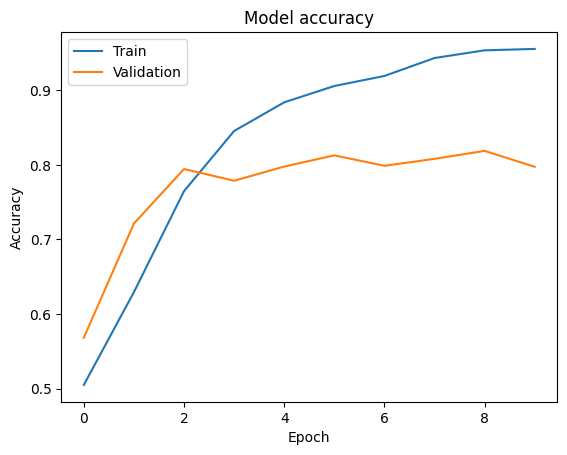

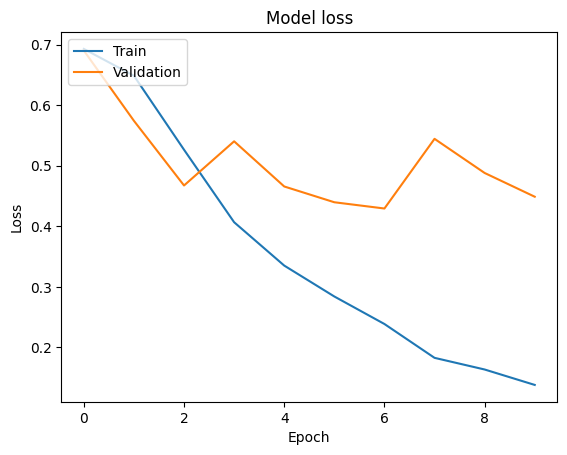

In [ ]:
import tensorflow as tf

def one_hot_lambda_function(x):
    return tf.one_hot(x, depth=max_tokens)

# Recreate the model architecture with the Lambda layer
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.keras.layers.Lambda(
    one_hot_lambda_function,
    output_shape=(None, max_tokens)  # Specify output shape here
)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
new_model = tf.keras.Model(inputs, outputs)

# Load the weights from the saved model
new_model.load_weights("one_hot_bidir_lstm.keras")

new_model.compile(optimizer="rmsprop",
                     loss="binary_crossentropy",
                     metrics=["accuracy"])
print(f"Test acc: {new_model.evaluate(int_test_ds)[1]:.3f}")

# Now, you should be able to evaluate the model
print(f"Test acc: {new_model.evaluate(int_test_ds)[1]:.3f}")

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Instantiating an embedded layer

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 247ms/step - accuracy: 0.5065 - loss: 0.6936 - val_accuracy: 0.5667 - val_loss: 0.6845
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.6192 - loss: 0.6623 - val_accuracy: 0.6683 - val_loss: 0.6144
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - accuracy: 0.7044 - loss: 0.5664 - val_accuracy: 0.7710 - val_loss: 0.4958
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.8218 - loss: 0.4220 - val_accuracy: 0.7750 - val_loss: 0.4757
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.8591 - loss: 0.3488 - val_accuracy: 0.7817 - val_loss: 0.4649
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 253ms/step - accuracy: 0.8958 - loss: 0.2796 - val_accuracy: 0.7933 - val_loss: 0.4721
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 232ms/step - accuracy: 0.9321 - loss: 0.2014 - val_accuracy: 0.7980 - val_loss: 0.6213
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step - accuracy: 0.9525 - loss: 0

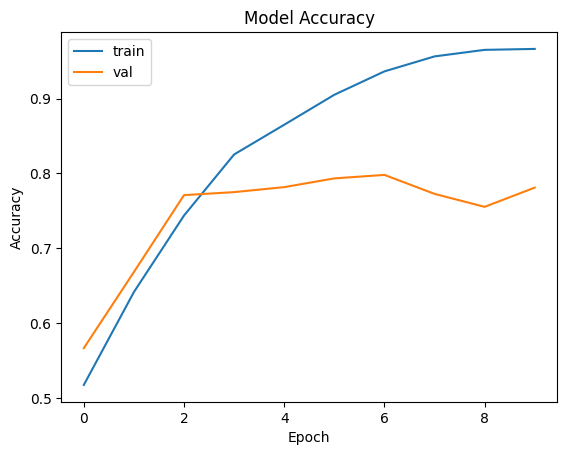

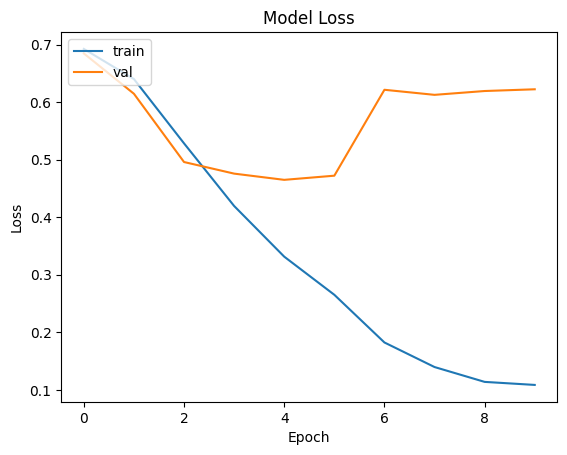

In [ ]:
import matplotlib.pyplot as plt

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]

history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Embedded Layer with Masking enables

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │      2,560,000 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 64)             │         73,984 │ embedding_1[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             65 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 307ms/step - accuracy: 0.5184 - loss: 0.6909 - val_accuracy: 0.6523 - val_loss: 0.6391
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 304ms/step - accuracy: 0.6835 - loss: 0.6016 - val_accuracy: 0.7940 - val_loss: 0.4627
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 355ms/step - accuracy: 0.7901 - loss: 0.4495 - val_accuracy: 0.8063 - val_loss: 0.4474
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 343ms/step - accuracy: 0.8714 - loss: 0.3240 - val_accuracy: 0.7880 - val_loss: 0.4783
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 301ms/step - accuracy: 0.8990 - loss: 0.2486 - val_accuracy: 0.6977 - val_loss: 0.7427
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 393ms/step - accuracy: 0.9252 - loss: 0.1861 - val_accuracy: 0.7940 - val_loss: 0.4952
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 301ms/step - accuracy: 0.9586 - loss: 0.1162 - val_accuracy: 0.7863 - val_loss: 0.5153
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 354ms/step - accuracy: 0.9771 - loss: 0

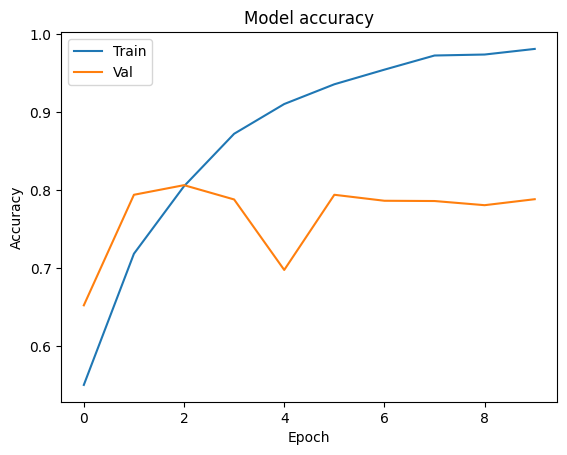

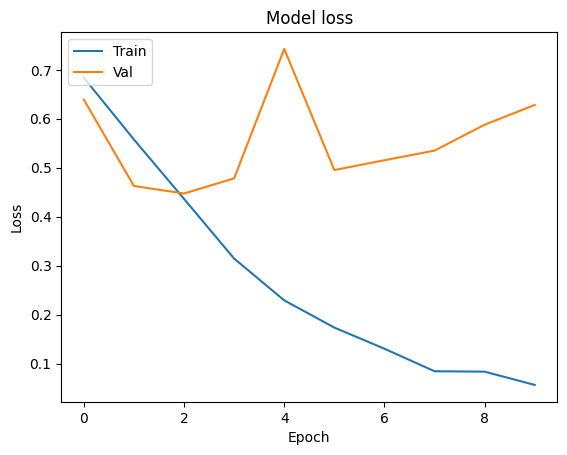

In [ ]:

import matplotlib.pyplot as plt

# Define the model architecture
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

# Define the callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True),
    keras.callbacks.History()
]

# Train the model
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

# Load the best model
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Pretrained word embeddings

--2025-04-07 00:22:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-07 00:22:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-07 00:22:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 64)             │         34,048 │ embedding_2[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             65 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 258ms/step - accuracy: 0.5148 - loss: 0.7074 - val_accuracy: 0.6137 - val_loss: 0.6634
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.6170 - loss: 0.6573 - val_accuracy: 0.6817 - val_loss: 0.5965
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.6726 - loss: 0.5940 - val_accuracy: 0.6990 - val_loss: 0.5748
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - accuracy: 0.7251 - loss: 0.5557 - val_accuracy: 0.7527 - val_loss: 0.5188
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.7330 - loss: 0.5321 - val_accuracy: 0.7527 - val_loss: 0.5123
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.7530 - loss: 0.5119 - val_accuracy: 0.7577 - val_loss: 0.5075
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 296ms/step - accuracy: 0.7681 - loss: 0.4878 - val_accuracy: 0.7773 - val_loss: 0.4738
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 218ms/step - accuracy: 0.7758 - loss: 0

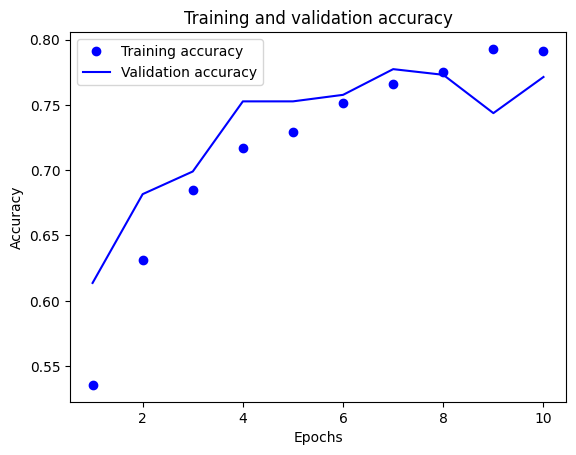

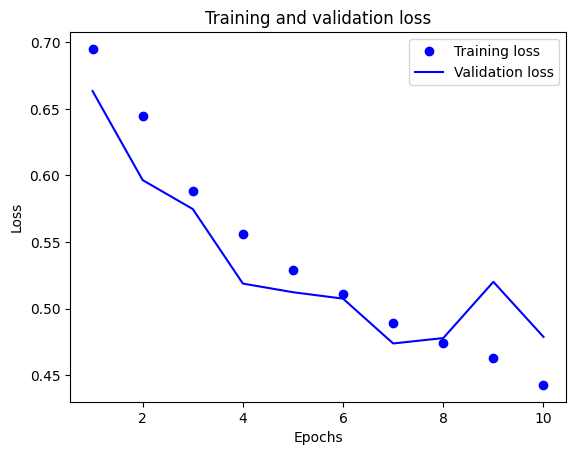

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

embedding_dim = 100
max_tokens = 10000
max_len = 150
num_samples = 100
validation_samples = 10000

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
word_index = {k: v for k, v in word_index.items() if v < max_tokens}

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]


history = model.fit(int_train_ds.take(num_samples).cache(),
          validation_data=int_val_ds.take(validation_samples).cache(),
          epochs=10, callbacks=callbacks)

model = keras.models.load_model("glove_embeddings_sequence_model.keras")
_, test_acc = model.evaluate(int_test_ds.take(validation_samples))
print(f"Test acc: {test_acc:.3f}")

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Changing no of training samples

Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - accuracy: 0.5531 - loss: 0.6866 - val_accuracy: 0.5970 - val_loss: 0.6621
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 287ms/step - accuracy: 0.7148 - loss: 0.5660 - val_accuracy: 0.6650 - val_loss: 0.7261
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.8145 - loss: 0.4199 - val_accuracy: 0.7860 - val_loss: 0.4566
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - accuracy: 0.8704 - loss: 0.3005 - val_accuracy: 0.8130 - val_loss: 0.4061
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - accuracy: 0.9127 - loss: 0.2357 - val_accuracy: 0.8120 - val_loss: 0.4542
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 307ms/step - accuracy: 0.9353 - loss: 0.1

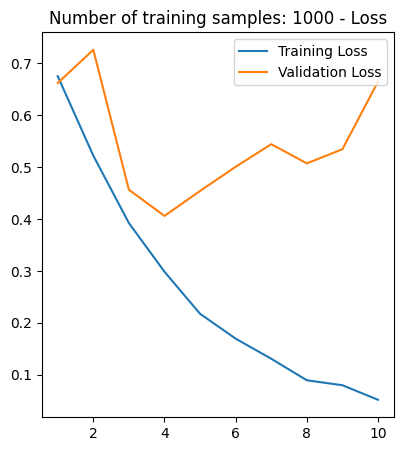

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 315ms/step - accuracy: 0.5422 - loss: 0.6873 - val_accuracy: 0.5570 - val_loss: 0.7285
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - accuracy: 0.7035 - loss: 0.5690 - val_accuracy: 0.7900 - val_loss: 0.4438
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.8249 - loss: 0.4146 - val_accuracy: 0.7100 - val_loss: 0.5940
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - accuracy: 0.8696 - loss: 0.3197 - val_accuracy: 0.8080 - val_loss: 0.4251
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - accuracy: 0.8939 - loss: 0.2515 - val_accuracy: 0.8070 - val_loss: 0.4729
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.9440 - loss: 0.1634 - val_accuracy: 0.8130 - val_loss: 0.5076
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 277ms/step - accuracy: 0

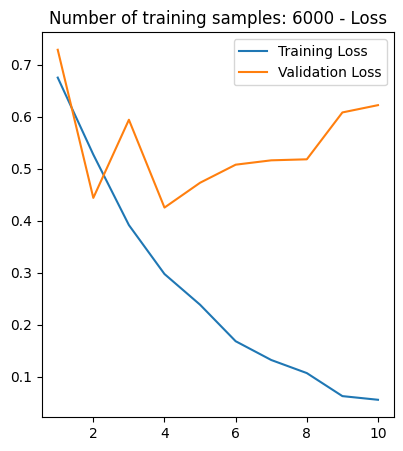

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 314ms/step - accuracy: 0.5357 - loss: 0.6882 - val_accuracy: 0.5370 - val_loss: 0.7117
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 314ms/step - accuracy: 0.7173 - loss: 0.5635 - val_accuracy: 0.7620 - val_loss: 0.4986
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 291ms/step - accuracy: 0.8203 - loss: 0.4075 - val_accuracy: 0.8030 - val_loss: 0.4196
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 271ms/step - accuracy: 0.8804 - loss: 0.3020 - val_accuracy: 0.8140 - val_loss: 0.4070
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 279ms/step - accuracy: 0.9201 - loss: 0.2385 - val_accuracy: 0.8140 - val_loss: 0.4553
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 271ms/step - accuracy: 0.9453 - loss: 0.1523 - val_accuracy: 0.8130 - val_loss: 0.4844
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 278ms/step - accuracy: 0

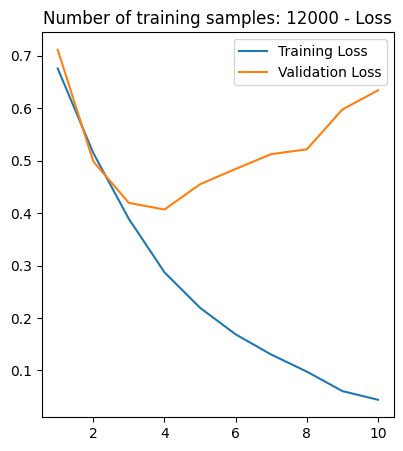

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 312ms/step - accuracy: 0.5497 - loss: 0.6837 - val_accuracy: 0.7250 - val_loss: 0.5553
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 285ms/step - accuracy: 0.7359 - loss: 0.5415 - val_accuracy: 0.7530 - val_loss: 0.5057
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.8198 - loss: 0.4143 - val_accuracy: 0.7530 - val_loss: 0.5521
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 288ms/step - accuracy: 0.8711 - loss: 0.3254 - val_accuracy: 0.8010 - val_loss: 0.4292
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 294ms/step - accuracy: 0.9012 - loss: 0.2444 - val_accuracy: 0.8180 - val_loss: 0.5146
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 289ms/step - accuracy: 0.9374 - loss: 0.1636 - val_accuracy: 0.7960 - val_loss: 0.5324
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 301ms/step - accuracy: 0

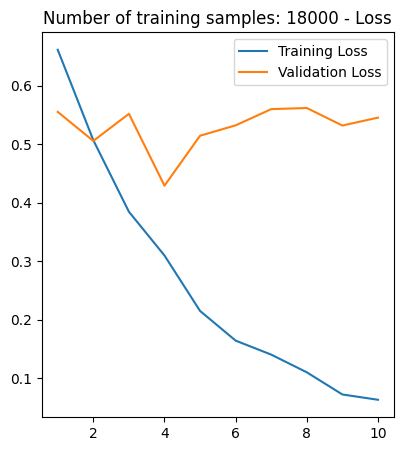

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - accuracy: 0.5346 - loss: 0.6862 - val_accuracy: 0.6490 - val_loss: 0.6221
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 295ms/step - accuracy: 0.7040 - loss: 0.5707 - val_accuracy: 0.7290 - val_loss: 0.5543
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 295ms/step - accuracy: 0.8039 - loss: 0.4396 - val_accuracy: 0.8010 - val_loss: 0.4405
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 286ms/step - accuracy: 0.8673 - loss: 0.3247 - val_accuracy: 0.8170 - val_loss: 0.4150
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.9058 - loss: 0.2623 - val_accuracy: 0.8160 - val_loss: 0.4781
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.9321 - loss: 0.1848 - val_accuracy: 0.8130 - val_loss: 0.4941
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - accuracy: 0

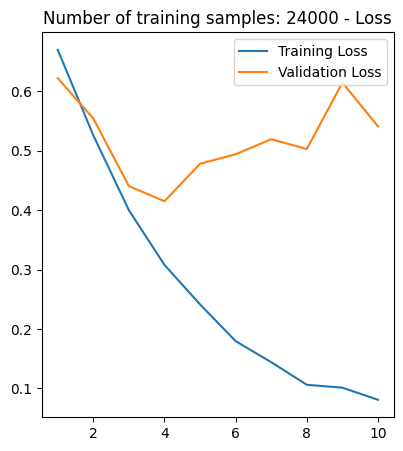

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.5581 - loss: 0.6852 - val_accuracy: 0.6180 - val_loss: 0.6648
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 275ms/step - accuracy: 0.7107 - loss: 0.5658 - val_accuracy: 0.7900 - val_loss: 0.4439
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.8161 - loss: 0.4248 - val_accuracy: 0.7580 - val_loss: 0.5337
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - accuracy: 0.8700 - loss: 0.3189 - val_accuracy: 0.8060 - val_loss: 0.4166
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.9010 - loss: 0.2487 - val_accuracy: 0.8100 - val_loss: 0.4479
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 293ms/step - accuracy: 0.9434 - loss: 0.1564 - val_accuracy: 0.8070 - val_loss: 0.5337
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - accuracy: 0

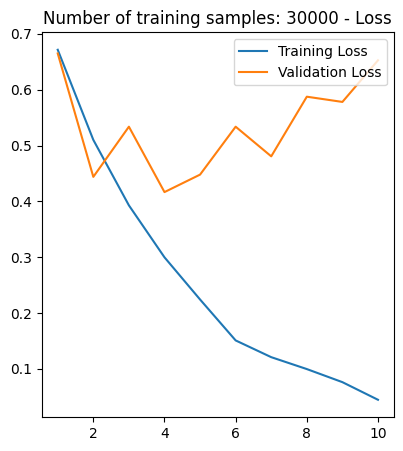

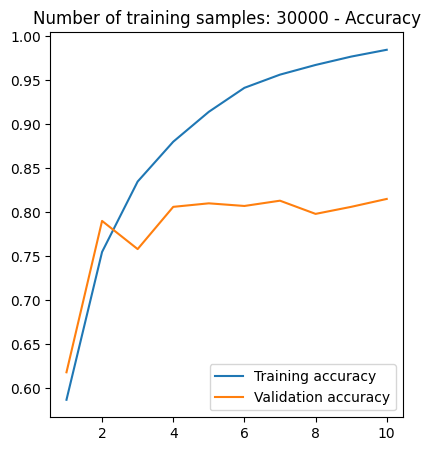

In [ ]:
import os, pathlib, shutil, random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 32
max_length = 150
max_tokens = 10000
num_val_samples = 10000

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples_cat = int(num_val_samples/2)
    val_files = files[-num_val_samples_cat:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

test_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

text_only_train_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337).map(lambda x, y: x)

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(text_only_train_ds)

for num_train_samples in [1000, 6000, 12000, 18000, 24000, 30000]:
    train_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='training',
        seed=1337
    ).take(num_train_samples)

    val_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='validation',
        seed=1337
    ).take(num_val_samples)

    int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(
        input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint(f"embeddings_bidir_gru_with_masking_{num_train_samples}.keras",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

    model = keras.models.load_model(f"embeddings_bidir_gru_with_masking_{num_train_samples}.keras")
    test_acc = model.evaluate(int_test_ds)[1]
    print(f"Number of training samples: {num_train_samples} - Test accuracy: {test_acc:.3f}")



    # Plot the training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Number of training samples: {num_train_samples} - Loss')

    plt.show()

#Plot the training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title(f'Number of training samples: {num_train_samples} - Accuracy')
plt.show()